# Intento 2

## 0. Descarga del dataset

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

train_ds_path  ='../../deeplearning-az/datasets/' \
                'Part 2 - Convolutional Neural Networks (CNN)/dataset/training_set'
test_ds_path   ='../../deeplearning-az/datasets/' \
                'Part 2 - Convolutional Neural Networks (CNN)/dataset/test_set'
cat_or_dog_path='../../deeplearning-az/datasets/' \
                'Part 2 - Convolutional Neural Networks (CNN)/dataset/single_prediction/cat_or_dog_1.jpg'


train_ds_path  ='.\\data\\training_set'
test_ds_path   ='.\\data\\test_set'
cat_or_dog_path='.\\data\\single_prediction\\cat_or_dog_1.jpg'


Primero, importar las librerías y paquetes

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
# Nota, algunas capas no están importadas aquí y se importan directamente en el código con tf.keras.laters.[CAPA]

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import random as rn

Fijamos seeds para poder reproducir resultados (aunque aun así a veces no lo conseguimos, probablementa haya inicializaciones que no dependan de estas seeds)

In [4]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(1234)

## 1. Construcción del modelo CNN añadiendo una capa de dropout


El modelo empleado es el mismo que el modelo base, con la única diferencia de que añadimos una capa de dropout (20%) antes de la última neurona, tratando de reducir el *overfitting*.

El tamaño de imagen que emplearemos será de 64x64.

In [5]:
frame_size = (64, 64)
"""
esta dupla nos permitirá parametrizar la resolución
de entrada de las imágenes
"""

def crear_clasificador_intento2():
    classifier = Sequential()
    classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (*frame_size, 3), activation = "relu"))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    classifier.add(Flatten())
    classifier.add(Dense(units = 128, activation = "relu"))
    classifier.add(Dropout(0.2))
    classifier.add(Dense(units = 1, activation = "sigmoid"))    
    return classifier

## 2. Entrenamiento del intento 2

En primer lugar instanciamos nuestro modelo y compilamos usando:
* Un optimizador Adam. La learning rate que emplea por defecto es 0.001
* Binary cross entropy como función de coste a minimizar.  

In [6]:
classifier = crear_clasificador_intento2()
classifier.compile(optimizer = "adam", 
                   loss = "binary_crossentropy", 
                   metrics = ["accuracy"])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

En segundo lugar, generamos los datasets de entrenamiento y test. Emplearemos un tamaño de batch de 32

In [7]:
from keras.preprocessing.image import ImageDataGenerator

batch_size=32 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(train_ds_path,
                                                     target_size=frame_size,
                                                     batch_size=batch_size,
                                                     class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(test_ds_path,
                                                   target_size=frame_size,                                                   
                                                   batch_size=batch_size,
                                                   class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Definimos el callback y realizamos el entrenamiento con las condiciones descritas en la sección de introducción.

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience=5),
]                                                   
                                                   
history2 = classifier.fit(x=training_dataset,
                         steps_per_epoch=8000/batch_size,
                         epochs=100,
                         validation_data=testing_dataset,
                         validation_steps=2000/batch_size,
                         workers=4,
                         callbacks=callbacks) # "Si pedimos más de un proceso el rendimiento mejora un poco


Epoch 1/100
250/250 [==============================] - 48s 189ms/step - loss: 0.6844 - accuracy: 0.5561 - val_loss: 0.6235 - val_accuracy: 0.6495
Epoch 2/100
250/250 [==============================] - 45s 178ms/step - loss: 0.6108 - accuracy: 0.6583 - val_loss: 0.5650 - val_accuracy: 0.7180
Epoch 3/100
250/250 [==============================] - 46s 185ms/step - loss: 0.5574 - accuracy: 0.7185 - val_loss: 0.5407 - val_accuracy: 0.7310
Epoch 4/100
250/250 [==============================] - 44s 176ms/step - loss: 0.5351 - accuracy: 0.7301 - val_loss: 0.5244 - val_accuracy: 0.7455
Epoch 5/100
250/250 [==============================] - 40s 161ms/step - loss: 0.5041 - accuracy: 0.7529 - val_loss: 0.5006 - val_accuracy: 0.7570
Epoch 6/100
250/250 [==============================] - 46s 184ms/step - loss: 0.4851 - accuracy: 0.7672 - val_loss: 0.5322 - val_accuracy: 0.7285
Epoch 7/100
250/250 [==============================] - 58s 228ms/step - loss: 0.4729 - accuracy: 0.7789 - val_loss: 0.4866 -

Ploteamos el resultado

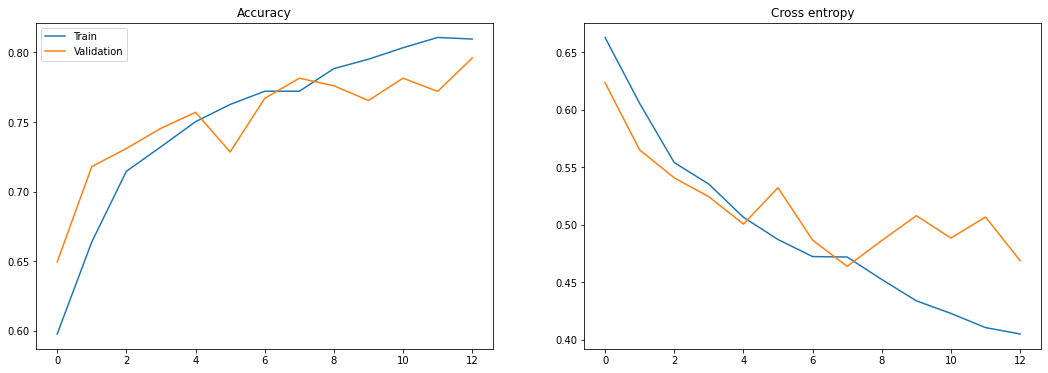

In [9]:
def plot_resultados_training(history):
    fig, axes = plt.subplots(1,2, figsize=(18,6))
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].legend()
    axes[0].set_title('Accuracy')
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Cross entropy')
plot_resultados_training(history2)

In [10]:
classifier.save('.\\models\\clasificador2')

INFO:tensorflow:Assets written to: .\models\clasificador2\assets


### Comentario
El resultado de la precisión de la validación ha mejorado un uno por ciento y el entrenamiento ha bajado més de tres puntos. Así pues parece que hemos conseguido reducir el sobre-entrenamiento. 

### Propuesta de mejora
Pensamos que para seguir reduciendo el diferencial entre las precisiones (y los valores de pérdida) entre entrenamiento y validación podemos aumentar algo más el tanto por ciento de pesos no actualizados 
en la siguiente versión. 

También hemos visto que las imágenes tienen en su mayoría resoluciones de 500 por 400 píxeles aproximadamente y quizás también estemos perdiendo demasiada información al pasarlas a 64x64, 
así que en la próxima versión las trataremos como iḿagenes de 96x96 píxeles. 